# Checking local model

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
% matplotlib inline
import logging
import os

from madminer.sampling import SampleAugmenter
from madminer.sampling import multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas

logging.basicConfig(format='%(asctime)s  %(message)s', datefmt='%H:%M')



In [2]:
base_dir = '/Users/johannbrehmer/work/projects/madminer/diboson_mining/'
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/'

In [3]:
sample_dir = base_dir + 'data/samples/wgamma/'
card_dir = base_dir + 'cards/wgamma/'
ufo_model_dir = card_dir + 'SMWgamma_UFO'
run_card_dir = card_dir + 'run_cards/'
mg_process_dir = base_dir + 'data/mg_processes/wgamma/'
log_dir = base_dir + 'logs/wgamma/'
temp_dir = base_dir + 'data/temp'
delphes_dir = mg_dir + 'Delphes'

## Get joint ratios and scores

In [4]:
sa = SampleAugmenter(sample_dir + 'samples_tight.h5', debug=False)

10:47  
10:47  ------------------------------------------------------------
10:47  |                                                          |
10:47  |  MadMiner v2018.11.13                                    |
10:47  |                                                          |
10:47  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
10:47  |                                                          |
10:47  ------------------------------------------------------------
10:47  
10:47  Loading data from /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/samples/wgamma/samples_tight.h5
10:47  Found 2 parameters:
10:47     cWWW (LHA: dim6 1, maximal power in squared ME: (2,), range: (-0.02, 0.02))
10:47     cWWWtilde (LHA: dim6 2, maximal power in squared ME: (2,), range: (-0.02, 0.02))
10:47  Found 6 benchmarks:
10:47     sm: cWWW = 0.00e+00, cWWWtilde = 0.00e+00
10:47     morphing_basis_vector_1: cWWW = -6.07e-03, cWWWtilde = -1.84e-02
10:47     morphing_basis_vect

In [6]:
help(sa.extract_samples_train_ratio)

Help on method extract_samples_train_ratio in module madminer.sampling:

extract_samples_train_ratio(theta0, theta1, n_samples, folder, filename, test_split=0.5, switch_train_test_events=False) method of madminer.sampling.SampleAugmenter instance
    Extracts training samples `x ~ p(x|theta0)` and `x ~ p(x|theta1)` together with the class label `y`, the joint
    likelihood ratio `r(x,z|theta0, theta1)`, and the joint score `t(x,z|theta0)`. This information can be used in
    inference methods such as CARL, ROLR, CASCAL, and RASCAL.
    
    Parameters
    ----------
    theta0 : tuple
        Tuple (type, value) that defines the numerator parameter point or prior over parameter points for the
        sampling. Pass the output of the functions `constant_benchmark_theta()`, `multiple_benchmark_thetas()`,
        `constant_morphing_theta()`, `multiple_morphing_thetas()`, or `random_morphing_thetas()`.
    
    theta1 : tuple
        Tuple (type, value) that defines the denominator parame

In [33]:
_, theta0_0, _, _, r_xz_0, t_xz_0 = sa.extract_samples_train_ratio(
        theta0=random_morphing_thetas(100, [('gaussian', 0., 0.001), ('gaussian', 0., 0.000001)]),
        theta1=constant_morphing_theta([0.,0.]),
        n_samples=10000,
        folder=None,
        filename=None
    )

11:09  Extracting training sample for ratio-based methods. Numerator hypothesis: ('random', (100, [('gaussian', 0.0, 0.001), ('gaussian', 0.0, 1e-06)])), denominator hypothesis: ('theta', array([0., 0.]))
11:09  Effective number of samples: mean 2247.530095191648, with individual thetas ranging from 1018.3941471222727 to 2289.329579938781
11:09  Effective number of samples: mean 2289.4849728559093, with individual thetas ranging from 2289.484972855909 to 2289.484972855909


In [34]:
_, theta0_1, _, _, r_xz_1, t_xz_1 = sa.extract_samples_train_ratio(
        theta0=random_morphing_thetas(100, [('gaussian', 0., 0.000001), ('gaussian', 0., 0.001)]),
        theta1=constant_morphing_theta([0.,0.]),
        n_samples=10000,
        folder=None,
        filename=None
    )

11:09  Extracting training sample for ratio-based methods. Numerator hypothesis: ('random', (100, [('gaussian', 0.0, 1e-06), ('gaussian', 0.0, 0.001)])), denominator hypothesis: ('theta', array([0., 0.]))
11:10  Effective number of samples: mean 2237.856106860685, with individual thetas ranging from 909.6252229731813 to 2289.4063408348447
11:10  Effective number of samples: mean 2289.4849728559093, with individual thetas ranging from 2289.484972855909 to 2289.484972855909


In [35]:
tthat_0 = np.einsum("ni,ni->n", t_xz_0, theta0_0)
tthat_1 = np.einsum("ni,ni->n", t_xz_1, theta0_1)

logr_0 = np.log(r_xz_0)
logr_1 = np.log(r_xz_1)

dtheta_0 = np.linalg.norm(theta0_0, axis=1)
dtheta_1 = np.linalg.norm(theta0_1, axis=1)

## Plot r vs t

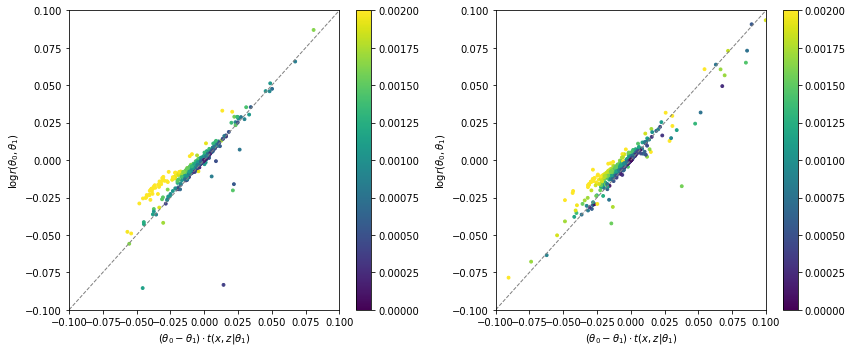

In [41]:
skip=10
xmin0, xmax0 = -0.1, 0.1
xmin1, xmax1 = -0.1, 0.1

fig = plt.figure(figsize=(12,5))

ax = plt.subplot(1,2,1)
plt.plot([-10.,10.], [-10.,10.], lw=1., ls='--', c='0.5')
sc = plt.scatter(tthat_0[::skip], logr_0[::skip],
                 c=dtheta_0[::skip], cmap='viridis', vmin=0., vmax=0.002,
                 s=8., alpha=1.)
plt.colorbar(sc)
plt.xlim(xmin0, xmax0)
plt.ylim(xmin0, xmax0)
plt.ylabel(r'$\log r(\theta_0, \theta_1)$')
plt.xlabel(r'$(\theta_0 - \theta_1) \cdot t(x,z | \theta_1)$')

ax = plt.subplot(1,2,2)
plt.plot([-10.,10.], [-10.,10.], lw=1., ls='--', c='0.5')
sc = plt.scatter(tthat_1[::skip], logr_1[::skip],
                 c=dtheta_1[::skip], cmap='viridis', vmin=0., vmax=0.002,
                 s=8., alpha=1.)
plt.colorbar(sc)
plt.xlim(xmin1, xmax1)
plt.ylim(xmin1, xmax1)
plt.ylabel(r'$\log r(\theta_0, \theta_1)$')
plt.xlabel(r'$(\theta_0 - \theta_1) \cdot t(x,z | \theta_1)$')

plt.tight_layout()
plt.savefig('local_model_breakdown.pdf')
